In [1]:
import numpy as np
f = open('live_record(1.567G, 50MHz, 25dB, 5M)_230513_2013_102s_SDR_검증.bin', 'rb')
data = np.fromfile(f, dtype=np.int16, count = int(50e6*10*2))
f.close()
# 측정값 오류로 인한 값들 양옆 중간값으로 치환
for i in range(0,len(data),250001):
    data[i] = (data[i-2]+ data[i+2]) / 2
    data[i+1] = (data[i-1] + data[i+3]) / 2

real = data[::2]
print(np.average(np.abs(real)))
imag = data[1::2]
print(np.average(np.abs(imag)))
signal_data = real + 1j*imag

# 최대 나올 수 있는 peak 약 1100만

157.931046974
157.938369832


In [2]:
import matplotlib.pyplot as plt
from scipy.signal import correlate, butter, lfilter

from mpl_toolkits.mplot3d import Axes3D
from collections import deque  

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))


In [3]:
# 50MHz Sampling, 1.023MHz C/A code chip rate
# 50/1.023 samples per chip 
# Chip 마다 48 또는 49개의 sample이 생성된다는 건데 (48.87)
# 이 값들이 반복되는 주기를 구해야 함. 즉 (50 / 1.023) * X가 정수가 되기 위한 X의 최솟값
# 구해보면 1023 chip 마다 정수배가 되니까 (50000 sample 째에서 정수가 됨)
# C/A 코드 한 주기(1023 Chip 안에서 정해짐)
# 이만큼만 반복문 돌려서 각 chip당 몇 sample 넣을 건지 계산하면 됨

sample_count = []
cur = 0

for i in range(1,1024):
    cur = 50 * i /1.023
    sample_count.append(int(round(cur - round(50 * (i-1) / 1.023))))
    
#print(*sample_count)
#print(sum(sample_count))

In [4]:
fs = 50e6
lpf_cutoff = 2e6

def downconvert_and_filter(signal, fs, carrier_freq, lpf_cutoff):
    # 시간 축 생성
    t = np.arange(len(signal)) / fs

    # 다운컨버팅을 위한 복소 지수 신호 생성
    downconversion_signal = np.exp(-1j * 2 * np.pi * carrier_freq * t)

    # 신호를 베이스밴드로 변환
    baseband_signal = signal * downconversion_signal

    # 저역통과 필터 설계
    nyquist_rate = fs / 2.0
    normalized_cutoff = lpf_cutoff / nyquist_rate
    b, a = butter(N=2, Wn=normalized_cutoff, btype='low')

    # 필터를 실수부와 허수부에 각각 적용
    baseband_signal_real = lfilter(b, a, np.real(baseband_signal))
    baseband_signal_imag = lfilter(b, a, np.imag(baseband_signal))

    # 필터링된 베이스밴드 신호 생성
    baseband_signal_filtered = baseband_signal_real + 1j * baseband_signal_imag

    return baseband_signal_filtered
# 기존 코드에서 가져와야 하는 것들
# 1. Replica 클래스 : C/A 코드 생성 적절하게 맞춰서 해야함 
# 그런데 이놈의 t는 어떻게 다뤄야 할지 생각해야 됨. 그냥 하면 되나?
# 2. Acquisition(일단 첫번째 목표), 위성번호는 matlab 파일에 나와 있으니까(5번이었나?)
# 해당 위성 번호 기준으로 Acquisition 돌렸을 때 제대로 peak가 나오는지 확인(가장 먼저 해야할 것)
# 더 이상 OV가 정수가 아니므로 코드들 적절하게 수정할 필요 있음
# 한 Chip 주기 당 50000개 sample(1ms), 한 bit면 백 만개 sample(0.02초, 20ms, chip 주기 20번)

In [5]:
class MA_Filter:
    def __init__(self, signal, IF_freq):
        self.t = np.arange(0, 100000) / (50e6)
        base_carrier = np.exp(-1j * 2 * np.pi * IF_freq * self.t) 
        self.BB_signal = signal * base_carrier
    
    def extract(self, doppler_freq):
        
        # Doppler frequency로 내리기
        e = np.exp(-1j * 2 * np.pi * doppler_freq * self.t)
        target =  downconvert_and_filter(self.BB_signal, fs, doppler_freq, lpf_cutoff)
        
        # 절반 chip 만큼씩 step을 밟으면서, 1chip 길이의 합을 저장
        Ma = []
        pos = 0
        i = 0
        half = 1
        # 두 바퀴
        pos_lst = [0]
        
        doublecount = sample_count + sample_count
        try:
            while pos < 100000:
                if doublecount[i] == 48:
                    m = np.sum(target[pos:pos + 48])
                    Ma = np.append(Ma, m)
                    pos += 24
                elif doublecount[i] == 49:
                    if half == 1:
                        m = np.sum(target[pos:pos + 49])
                        Ma = np.append(Ma, m)
                        pos += 24
                    else:
                        m = np.sum(target[pos:pos + 49])
                        Ma = np.append(Ma, m)
                        pos += 25
                if half == -1:
                    i += 1
                half *= -1
                pos_lst.append(pos)
                
        except IndexError:
            np.append(Ma,np.sum(signal_data[99975:100024]))
          
        # 검사(길이가 4092인지)
        # print('length : ', len(Ma))
        return Ma, pos_lst
    
              

In [6]:
def acquisition(signal, code_delay_range, doppler_freq_range, IF_freq, svNumber):
    
    print('========== Acquisition Process ==========')
    frac_signal = signal[:100000]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset '대략적으로' 찾기)

    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    code_delay_sample = 0
    
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    
    Ma = MA_Filter(frac_signal, IF_freq)

    code = codes[svNumber]
    for i, doppler_freq in enumerate(doppler_freq_range):
        
        # 시간측정용
        print(f"Checking for {int(doppler_freq)}Hz...", end = " ")
        
        target, pos_lst = Ma.extract(doppler_freq)
        
        for j, code_delay in enumerate(code_delay_range):
            
            # Target의 간격은 반 chip
            current_pos = target[j:j+2046:2]
            
            # Correlation
            cor = np.abs(np.sum(current_pos * code))
            peak = np.max(cor) 
            corr_matrix[j, i] = peak
            
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
                code_delay_sample = pos_lst[j]
        print("Done")

    
    print('-'*40)
    print('Frame Sync complete.')
    print('Frame delay :', max_code_delay)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    return max_code_delay, max_doppler_freq, corr_matrix, code_delay_sample

In [7]:
code_delay_range = np.arange(0, 1023, 0.5) # 50000 sample을 2046개로 나눔 (0.5chip 간격)
doppler_freq_range = np.linspace(-5000, 5000, 21)
IF_freq = 8.42e6

# 들어있는 위성 번호 : 5, 11, 13, 15, 20.
svNumber = 5

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, corr_matrix, code_delay_sample = acquisition(signal_data, code_delay_range, doppler_freq_range, IF_freq, svNumber - 1)

========== Acquisition Process ==========
Checking for -5000Hz... Done
Checking for -4500Hz... Done
Checking for -4000Hz... Done
Checking for -3500Hz... Done
Checking for -3000Hz... Done
Checking for -2500Hz... Done
Checking for -2000Hz... Done
Checking for -1500Hz... Done
Checking for -1000Hz... Done
Checking for -500Hz... Done
Checking for 0Hz... Done
Checking for 500Hz... Done
Checking for 1000Hz... Done
Checking for 1500Hz... Done
Checking for 2000Hz... Done
Checking for 2500Hz... Done
Checking for 3000Hz... Done
Checking for 3500Hz... Done
Checking for 4000Hz... Done
Checking for 4500Hz... Done
Checking for 5000Hz... Done
----------------------------------------
Frame Sync complete.
Frame delay : 164.0
Estimated_Frequency Offset : 500.0
Max correlation : 694914.828546077
----------------------------------------


In [8]:
# 지금 peak 값이 떠야 하는데, 안 뜨고 있는 상황임

# 24.09.16  t 범위 잘못 잡아서 안나오는 거였습니다 
#           peak값은 바닥에 깔린 값들에 비해 약 두 배정도 차이 있는 것 같음
#           그럼 SNR 값도 계산이 가능한가?
#           다만 지금 svNumber = 5, 20일 때만 peak가 뜨는 것 같음

# 24.09.27  Moving Average Filter 적용 성공
#           실행시간 17~18초에서 3초로 감소
#           하지만 peak 안뜨는 건 그대로

# 24.09.30  peak가 뜨는 경향은 있어서 교수님께 확인받음
#           OK 받았음
#           이제 Tracking으로

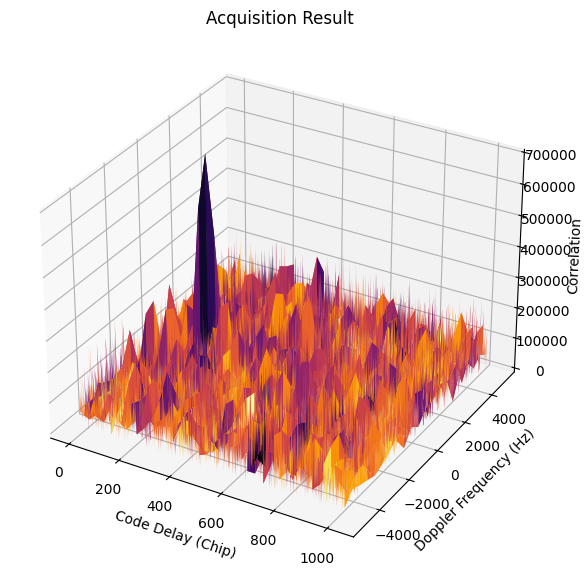

In [9]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='inferno_r')
ax.set_xlabel('Code Delay (Chip)')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Acquisition Result')
plt.show()

In [10]:
class Replica:
    def __init__(self, code_delay, doppler_freq, IF_freq, svNumber, t0): # t0 = 이전 carrier의 마지막 phase. Φ_n 
        ca_code = np.array(codes[svNumber])
        ca_code = [chip for chip, cnt in zip(ca_code, sample_count) for _ in range(cnt)] # chip 당 해당하는 sample 개수 만큼 늘이기
        self.delayed_code = np.roll(ca_code, code_delay)
    
        self.t = np.arange(0,50000) / 50e6
        self.oversampled_signal = np.exp(1j * (2 * np.pi * (doppler_freq ) * self.t + t0))   
                                                   
       # 다음 replica에서 사용할 Φ_(n+1) (누적), stay 판정 난 경우 가져올 값
        self.last = 2 * np.pi * (doppler_freq ) * (49999/50e6) + t0   # angle
        

    def delay(self, delay):
        self.delayed_code = np.roll(self.delayed_code, delay)
    def signal(self):
        return self.delayed_code * self.oversampled_signal

In [ ]:
#signal_data = downconvert_and_filter(signal_data, fs, IF_freq, lpf_cutoff)

from tqdm import tqdm
class Freq_discriminator:
    def __init__(self):
        self.temp = 250
        
    def calculate(self, data, i):
        Ip1 = np.real(self.temp)
        Qp1 = np.imag(self.temp)
        Ip2 = np.real(data)
        Qp2 = np.imag(data)
        
        cross = Ip1 * Qp2 - Ip2 * Qp1
        dot = Ip1 * Ip2 + Qp1 * Qp2
        deg = np.arctan2(cross, dot)
    
        transition = False
        
        if abs(deg) > np.pi / 2:
            print(f'bit transition at {i}, deg = {np.degrees(deg)}')
            val = -np.pi + deg if deg > 0 else np.pi + deg
            transition = True
        else:
            val = deg
        #val = deg
            
        D = val / (1e-2 * 2*np.pi)
        
        self.temp = data
        
        return D, transition

#Initialization
current_code_delay = estimated_code_delay
delay = code_delay_sample
current_doppler_freq = estimated_doppler_freq
est_error_freq = 0
current_phase_offset = 0
stack_P = 0 # 초기에 시작할 Φ_0
temp = 0 # phase offset 이전 값 저장
#temp_2 = 0

b = 0 # bit boundary 감지 후 20개 모을 변수
start_pos = 0 # boundary 시작 지점
comp = [] # 20개 저장 후 bit decision


# Plot 할 것들(초기값으로 채워주기)
dop_freq_lst = [current_doppler_freq]
phase_offset_lst = [0]
phase_offset_lst_deg = [0]
code_delay_lst = [current_code_delay] 
cor_result = []
demod_result = []
bit = []

# 복조 결과
result = []
phi = 0

freq_disc = Freq_discriminator()
t = np.arange(0, 50000) / (50e6)
base_carrier = np.exp(-1j * 2 * np.pi * IF_freq * t)
cor_P = 0
bar = tqdm(range(10000), desc = "Process :")
try:
    for i in bar:
        bar.set_postfix({'현재 cor_P 값 :' : np.abs(cor_P)})
        frac_signal_P = signal_data[i*50000 : i*50000 + 50000]
        #frac_signal_L = signal_data[cur_pos + 24 : cur_pos + 24 + 50000]
        #frac_signal_E = signal_data[cur_pos - 24 : cur_pos - 24 + 50000]
         
        replica_P = Replica(delay, current_doppler_freq, IF_freq, svNumber - 1, stack_P)
        #bb = frac_signal_P * base_carrier
        frac_signal = downconvert_and_filter(frac_signal_P, fs, IF_freq, lpf_cutoff)
        # C/A code correlation
        cor_P = correlate(replica_P.signal(), frac_signal, mode = 'valid')
        cfp = np.max(cor_P)
        cor_P = np.max(cor_P)* np.exp(-1j * current_phase_offset)
        
    
        # Late 계산을 위한 code delay (Half chip)            
        replica_P.delay(24)
        cor_L = correlate(replica_P.signal(), frac_signal, mode = 'valid')
        cor_L = np.max(cor_L)* np.exp(-1j * current_phase_offset)     
        
        # Early 계산을 위한 code delay (Half chip)
        # 앞선 late에서 24를 당겨가서 여기선 한 chip 만큼 뒤로 당겨야 함
        replica_P.delay(-48)
        cor_E = correlate(replica_P.signal(), frac_signal, mode = 'valid')
        cor_E = np.max(cor_E)* np.exp(-1j * current_phase_offset)
        
        cor_result.append(cor_P)
        
        # FLL
        if i == 0:
            freq_disc.temp = 0
        try: 
            est_error_freq, transition = freq_disc.calculate(cfp, i)
        except IndexError:
            est_error_freq = est_error_freq
        
        if i == 0:
            D_temp = est_error_freq
            
        #주파수 update (FLL Loop Filter)
        # 1차
        #current_doppler_freq = current_doppler_freq * 0.7 + est_error_freq * 0.3
        # 2차
        #current_doppler_freq = current_doppler_freq + est_error_freq * 0.10119 + 0.002698 * (est_error_freq - D_temp)
        #current_doppler_freq = current_doppler_freq + est_error_freq * 0.35 + 0.01 * (est_error_freq - D_temp)
        #current_doppler_freq = current_doppler_freq + est_error_freq 
        
        
        dop_freq_lst.append(current_doppler_freq)
        D_temp = est_error_freq
        
        
        # PLL
        angle = np.angle(cor_P)
        if np.abs(angle) > np.pi / 2:
            if angle < 0:
                res = angle + np.pi
            else:
                res = angle - np.pi
        else: # np.pi /2 보다 작을 때(1사분면, 4사분면)
            res = angle

        # PLL Loop Filter
        # 1차
        #current_phase_offset = current_phase_offset * 0.7 + res * 0.3
        # 2차\
        #current_phase_offset = current_phase_offset + 0.0767 * res + 0.00154 * (res - temp)
        # 3차
        #phi += res
        #current_phase_offset = current_phase_offset + 1.565e-4 * phi + 0.0215 * res + 3.804e-7 *(res - 2*temp + temp_2)
        #temp_2 = temp
        
        temp = res
        
        # None
        #current_phase_offset += res
        
        stack_P = replica_P.last
        
        
        
        if res > np.pi :
            phase_offset_lst.append(res - 2 * np.pi)
            phase_offset_lst_deg.append(np.degrees(res - 2 * np.pi))
        else:
            phase_offset_lst.append(res)
            phase_offset_lst_deg.append(np.degrees(res))


        # DLL 
        IE = np.real(cor_E)
        QE = np.imag(cor_E)
        IL = np.real(cor_L)
        QL = np.imag(cor_L)
        e = (IE**2 + QE**2 - IL**2 - QL**2)/(IE**2 + QE**2 + IL**2 + QL**2)
        
        if abs(e) <= 0.5:
            current_code_delay = current_code_delay
            #print(f"{i}ms, P = {np.abs(cor_P)}, E = {np.abs(cor_E)}, L = {np.abs(cor_L)}, stay")
        else:    
            if e < -0.5:
                current_code_delay += 1.023/50
                delay += 1
                #print(f"{i}ms, P = {np.abs(cor_P)}, E = {np.abs(cor_E)}, L = {np.abs(cor_L)}, Late")
            elif e > 0.5:
                current_code_delay -= 1.023/50
                delay -= 1
                #print(f"{i}ms, P = {np.abs(cor_P)}, E = {np.abs(cor_E)}, L = {np.abs(cor_L)}, Early")
                
                
        code_delay_lst.append(current_code_delay)
    
        # Decision 
        if b == 0: # 아직 boundary 찾은 보고 없음
            if transition: # 최초 boundary 식별
                b += 1
                start_pos = i % 20 #가장 처음 지점부터 모을 것이기 때문에 그만큼 한번에 수집 (예 : 만약 46에서 찾았다면 bit 시작점은 6일 거임)
                if i - start_pos >= 20: # 지금 현재 위치가 멀리 떨어져 있다면(1bit보다 더) (예 : 46 - 6 = 40이고, 앞선 2bit는 아직 안넣음. 밑은 넣는 작업)
                    for j in range((i - start_pos) // 20):
                        # 20개 수집
                        c = np.sum(cor_result[start_pos + 20 * j : start_pos + 20 *(j+1)])    
                        if np.real(c) >= 0:
                            bit.append(1)
                        else:
                            bit.append(0)
                
        # 이후부턴 loop마다 1개 씩 수집, 20개가 차면 decision, bit 생성.
        elif b == 1: # 20개 수집 시작
            comp.append(cor_P)
            if len(comp) == 20:
                c = np.sum(comp)
                if np.real(c) >= 0:
                    bit.append(1)
                else:
                    bit.append(0)
                # 리스트 비움
                comp.clear()
            
        # 그래프 출력용
        if np.real(cor_P) >= 0:
            demod_result.append(1)
        else:
            demod_result.append(-1)
            
            
except IndexError or ValueError:
    print('end')        
# Demodulation
"""for i in range(ms//20):
    Decision_variable = np.average(cor_result[i*20:i*20+20])
    # cor_result.append(Decision_variable)
    if np.real(Decision_variable) > 0:
        result.append(1)
    else:
        result.append(-1)"""

Process ::   0%|          | 10/10000 [00:00<03:50, 43.29it/s, 현재 cor_P 값 :=8.34e+5]

bit transition at 5, deg = 111.38700287244474
bit transition at 10, deg = 115.11585654515969
bit transition at 11, deg = -120.74309055075294
bit transition at 15, deg = 113.94017205070713


Process ::   0%|          | 33/10000 [00:00<02:34, 64.67it/s, 현재 cor_P 값 :=7.26e+5]

bit transition at 20, deg = 106.22764906924094
bit transition at 25, deg = 108.85345201284143
bit transition at 30, deg = 126.30093171002993


Process ::   0%|          | 47/10000 [00:00<02:35, 64.16it/s, 현재 cor_P 값 :=7.65e+5]

bit transition at 35, deg = 128.26277708194766
bit transition at 40, deg = 97.70345478856177
bit transition at 45, deg = 109.34916268702868


Process ::   1%|          | 63/10000 [00:01<02:25, 68.17it/s, 현재 cor_P 값 :=6.01e+5]

bit transition at 50, deg = 102.88008000017359
bit transition at 51, deg = -97.95630720614778
bit transition at 55, deg = 125.00301642771046
bit transition at 60, deg = 115.28076455199076


Process ::   1%|          | 71/10000 [00:01<02:25, 68.29it/s, 현재 cor_P 값 :=7.7e+5] 

bit transition at 65, deg = 112.52163285723857
bit transition at 70, deg = 130.4805970575713
bit transition at 75, deg = 102.67606317660965


Process ::   1%|          | 93/10000 [00:01<02:25, 67.91it/s, 현재 cor_P 값 :=7.71e+5]

bit transition at 80, deg = 119.10284544830417
bit transition at 85, deg = 125.63922666144529
bit transition at 90, deg = 110.09979582774395
bit transition at 91, deg = -118.97157715625809


Process ::   1%|          | 108/10000 [00:01<02:26, 67.52it/s, 현재 cor_P 값 :=7.51e+5]

bit transition at 95, deg = 100.77959556478443
bit transition at 100, deg = 117.8741981425125
bit transition at 105, deg = 109.09999404861598


Process ::   1%|          | 124/10000 [00:01<02:21, 69.65it/s, 현재 cor_P 값 :=7.57e+5]

bit transition at 110, deg = 92.787523933413
bit transition at 115, deg = 105.9890168700761
bit transition at 120, deg = 105.20341098611046


Process ::   1%|▏         | 140/10000 [00:02<02:19, 70.85it/s, 현재 cor_P 값 :=6.86e+5]

bit transition at 125, deg = 112.094881134938
bit transition at 130, deg = 117.03905846123408
bit transition at 131, deg = -118.3548243000829
bit transition at 135, deg = 124.59167984147142


Process ::   1%|▏         | 148/10000 [00:02<02:32, 64.79it/s, 현재 cor_P 값 :=6.46e+5]

bit transition at 140, deg = 125.26398735768363
bit transition at 145, deg = 103.91126321142873
bit transition at 150, deg = 128.49482387870069
bit transition at 151, deg = -141.87530927820887


Process ::   2%|▏         | 164/10000 [00:02<02:21, 69.59it/s, 현재 cor_P 값 :=6.45e+5]

bit transition at 155, deg = 113.21305286853585
bit transition at 160, deg = 110.89897517113091
bit transition at 165, deg = 94.47456912495775


Process ::   2%|▏         | 180/10000 [00:02<02:16, 71.86it/s, 현재 cor_P 값 :=7.49e+5]

bit transition at 170, deg = 102.98872125897623
bit transition at 175, deg = 102.19309600304388
bit transition at 180, deg = 114.2739252008262


Process ::   2%|▏         | 196/10000 [00:02<02:14, 72.87it/s, 현재 cor_P 값 :=5.84e+5]

bit transition at 185, deg = 106.11975435816034
bit transition at 190, deg = 99.90721434931865
bit transition at 195, deg = 125.0510624756049


Process ::   2%|▏         | 211/10000 [00:03<02:37, 62.25it/s, 현재 cor_P 값 :=8.12e+5]

bit transition at 200, deg = 120.5944756384202
bit transition at 205, deg = 105.83287994182446
bit transition at 210, deg = 99.83082174740805


Process ::   2%|▏         | 225/10000 [00:03<02:32, 64.29it/s, 현재 cor_P 값 :=7.07e+5]

bit transition at 215, deg = 126.965432795802
bit transition at 220, deg = 101.45850371567526
bit transition at 225, deg = 103.50969894394753


Process ::   2%|▏         | 242/10000 [00:03<02:17, 71.08it/s, 현재 cor_P 값 :=6.73e+5]

bit transition at 230, deg = 122.89081623476764
bit transition at 231, deg = -115.49228206380954
bit transition at 235, deg = 99.95398632532552
bit transition at 240, deg = 113.78428551126404


Process ::   3%|▎         | 258/10000 [00:03<02:10, 74.44it/s, 현재 cor_P 값 :=5.68e+5]

bit transition at 245, deg = 106.57908113704386
bit transition at 250, deg = 109.1142521822736
bit transition at 251, deg = -118.0165127472311
bit transition at 255, deg = 112.39725411912224


Process ::   3%|▎         | 274/10000 [00:04<02:06, 77.09it/s, 현재 cor_P 값 :=6.14e+5]

bit transition at 260, deg = 136.7363691262166
bit transition at 265, deg = 97.59004680220652
bit transition at 270, deg = 111.62873950116852
bit transition at 271, deg = -115.07869710304071


Process ::   3%|▎         | 282/10000 [00:04<02:07, 76.02it/s, 현재 cor_P 값 :=7.68e+5]

bit transition at 275, deg = 122.84828860257277
bit transition at 280, deg = 103.65111482525313
bit transition at 285, deg = 123.88918098828067


Process ::   3%|▎         | 299/10000 [00:04<02:12, 73.20it/s, 현재 cor_P 값 :=6.88e+5]

bit transition at 290, deg = 111.37844865319282
bit transition at 291, deg = -114.38351268781024
bit transition at 295, deg = 113.72427745078642
bit transition at 300, deg = 105.74220356985147


Process ::   3%|▎         | 315/10000 [00:04<02:11, 73.78it/s, 현재 cor_P 값 :=6.75e+5]

bit transition at 305, deg = 108.84331298605973
bit transition at 310, deg = 120.96344918643807
bit transition at 315, deg = 101.0392727080093


Process ::   3%|▎         | 340/10000 [00:04<02:08, 75.05it/s, 현재 cor_P 값 :=7.6e+5] 

bit transition at 325, deg = 116.73780797002564
bit transition at 330, deg = 115.61164141448081
bit transition at 335, deg = 107.84989599764954


Process ::   4%|▎         | 356/10000 [00:05<02:07, 75.46it/s, 현재 cor_P 값 :=6.4e+5] 

bit transition at 345, deg = 99.40152954036114
bit transition at 350, deg = 123.407750888361
bit transition at 355, deg = 111.28086257178377


Process ::   4%|▎         | 372/10000 [00:05<02:16, 70.44it/s, 현재 cor_P 값 :=6.82e+5]

bit transition at 360, deg = 114.71212132220454
bit transition at 365, deg = 114.49962351922859
bit transition at 370, deg = 119.6437680985876


Process ::   4%|▍         | 388/10000 [00:05<02:13, 71.80it/s, 현재 cor_P 값 :=7.22e+5]

bit transition at 375, deg = 109.97182565598933
bit transition at 380, deg = 126.3760407293895
bit transition at 385, deg = 101.36141959673326


Process ::   4%|▍         | 404/10000 [00:05<02:10, 73.44it/s, 현재 cor_P 값 :=6.5e+5] 

bit transition at 390, deg = 122.39308283966129
bit transition at 391, deg = -124.31924036049618
bit transition at 395, deg = 115.42247528990184
bit transition at 400, deg = 105.07948277009696


Process ::   4%|▍         | 412/10000 [00:06<02:15, 70.58it/s, 현재 cor_P 값 :=6.55e+5]

bit transition at 405, deg = 114.30135085680662
bit transition at 410, deg = 108.09195728689582
bit transition at 411, deg = -123.34167824196487
bit transition at 415, deg = 112.45115161075309


Process ::   4%|▍         | 429/10000 [00:06<02:09, 73.99it/s, 현재 cor_P 값 :=7.4e+5] 

bit transition at 420, deg = 102.31376112741881
bit transition at 425, deg = 125.59166778154155
bit transition at 430, deg = 112.12993171553484


Process ::   4%|▍         | 445/10000 [00:06<02:18, 68.92it/s, 현재 cor_P 값 :=7.1e+5] 

bit transition at 435, deg = 129.99609422595708
bit transition at 440, deg = 122.54471030636931
bit transition at 445, deg = 94.51423161454434


Process ::   5%|▍         | 461/10000 [00:06<02:12, 71.80it/s, 현재 cor_P 값 :=5.9e+5] 

bit transition at 450, deg = 123.64696794924113
bit transition at 455, deg = 108.3523542421558
bit transition at 460, deg = 118.17066630187419


Process ::   5%|▍         | 476/10000 [00:06<02:27, 64.37it/s, 현재 cor_P 값 :=7.16e+5]

bit transition at 465, deg = 105.31157217519348
bit transition at 470, deg = 126.71394313577014
bit transition at 471, deg = -115.48276424780568
bit transition at 475, deg = 113.24930186132403


Process ::   5%|▍         | 491/10000 [00:07<02:22, 66.87it/s, 현재 cor_P 값 :=6.49e+5]

bit transition at 480, deg = 122.22543495603277
bit transition at 485, deg = 119.92460151532934
bit transition at 490, deg = 116.10860072494573
bit transition at 491, deg = -113.8750674049667


Process ::   5%|▍         | 498/10000 [00:07<02:39, 59.61it/s, 현재 cor_P 값 :=7.37e+5]

bit transition at 495, deg = 123.49895166874745
bit transition at 500, deg = 113.62252017188221


Process ::   5%|▌         | 515/10000 [00:07<02:21, 67.14it/s, 현재 cor_P 값 :=7.2e+5] 

bit transition at 505, deg = 113.56579804764256
bit transition at 510, deg = 109.70559659729588
bit transition at 511, deg = -124.80461823531397
bit transition at 515, deg = 121.9645149281539


Process ::   5%|▌         | 530/10000 [00:07<02:16, 69.30it/s, 현재 cor_P 값 :=6e+5]   

bit transition at 520, deg = 110.54337528867897
bit transition at 525, deg = 110.04022447543038
bit transition at 530, deg = 124.57129785583709


Process ::   5%|▌         | 546/10000 [00:07<02:10, 72.64it/s, 현재 cor_P 값 :=6.8e+5] 

bit transition at 535, deg = 114.13686609513596
bit transition at 540, deg = 113.9358184860787
bit transition at 545, deg = 106.68483758756173


Process ::   6%|▌         | 562/10000 [00:08<02:17, 68.39it/s, 현재 cor_P 값 :=7.57e+5]

bit transition at 550, deg = 115.45722090528008
bit transition at 551, deg = -107.11252396284421
bit transition at 555, deg = 115.37828231274844
bit transition at 560, deg = 123.59842768550476


Process ::   6%|▌         | 577/10000 [00:08<02:20, 66.88it/s, 현재 cor_P 값 :=6.56e+5]

bit transition at 565, deg = 122.982343313584
bit transition at 570, deg = 120.63462785170326
bit transition at 575, deg = 118.71738161579817
bit transition at 580, deg = 136.45156019866303


Process ::   6%|▌         | 593/10000 [00:08<02:09, 72.49it/s, 현재 cor_P 값 :=8.01e+5]

bit transition at 585, deg = 113.49531358747359
bit transition at 590, deg = 112.5002804633028
bit transition at 595, deg = 123.93409515058548


Process ::   6%|▌         | 609/10000 [00:08<02:07, 73.40it/s, 현재 cor_P 값 :=7.8e+5] 

bit transition at 600, deg = 121.19251493672405
bit transition at 605, deg = 118.91798602680447
bit transition at 610, deg = 110.81129083414228


Process ::   6%|▋         | 626/10000 [00:09<02:04, 75.45it/s, 현재 cor_P 값 :=8.25e+5]

bit transition at 615, deg = 110.11065234985897
bit transition at 620, deg = 119.64902811029884
bit transition at 625, deg = 110.91029180391425


Process ::   6%|▋         | 642/10000 [00:09<02:14, 69.40it/s, 현재 cor_P 값 :=6.22e+5]

bit transition at 630, deg = 124.46591790149421
bit transition at 635, deg = 107.77876219657759
bit transition at 640, deg = 101.04046411785785


Process ::   7%|▋         | 658/10000 [00:09<02:11, 70.81it/s, 현재 cor_P 값 :=7.17e+5]

bit transition at 645, deg = 115.8064599409581
bit transition at 650, deg = 124.78328938352526
bit transition at 655, deg = 96.0276348925245


Process ::   7%|▋         | 666/10000 [00:09<02:19, 66.78it/s, 현재 cor_P 값 :=6.05e+5]

bit transition at 660, deg = 121.77664764577501
bit transition at 665, deg = 112.34538447710948
bit transition at 670, deg = 119.42120912454156
bit transition at 671, deg = -106.05964608106255


Process ::   7%|▋         | 681/10000 [00:09<02:40, 57.98it/s, 현재 cor_P 값 :=7.29e+5]

bit transition at 675, deg = 110.36502798599253
bit transition at 680, deg = 127.75804080357643


Process ::   7%|▋         | 688/10000 [00:10<02:35, 59.76it/s, 현재 cor_P 값 :=6.77e+5]

bit transition at 685, deg = 111.93713211954685


Process ::   7%|▋         | 701/10000 [00:10<03:06, 49.80it/s, 현재 cor_P 값 :=7.45e+5]

bit transition at 690, deg = 111.06246630939663
bit transition at 695, deg = 101.46288701073641
bit transition at 700, deg = 116.4268848914217


Process ::   7%|▋         | 714/10000 [00:10<02:59, 51.75it/s, 현재 cor_P 값 :=7.22e+5]

bit transition at 705, deg = 114.75710702513042
bit transition at 710, deg = 110.99551308271279


Process ::   7%|▋         | 721/10000 [00:10<02:53, 53.58it/s, 현재 cor_P 값 :=7.35e+5]

bit transition at 715, deg = 112.76461722504342
bit transition at 720, deg = 112.41359951753678
bit transition at 725, deg = 120.1509299535446


Process ::   7%|▋         | 744/10000 [00:11<02:29, 61.89it/s, 현재 cor_P 값 :=7.34e+5]

bit transition at 730, deg = 112.74240506674049
bit transition at 731, deg = -106.76824858100399
bit transition at 735, deg = 111.85840303540117
bit transition at 740, deg = 103.54716283720131


Process ::   8%|▊         | 753/10000 [00:11<02:28, 62.13it/s, 현재 cor_P 값 :=7.69e+5]

bit transition at 745, deg = 103.77630274989377
bit transition at 750, deg = 108.7234075268443
bit transition at 751, deg = -125.00576828604758
bit transition at 755, deg = 121.92197249943789


Process ::   8%|▊         | 768/10000 [00:11<02:17, 67.29it/s, 현재 cor_P 값 :=7.84e+5]

bit transition at 760, deg = 113.79410221496228
bit transition at 765, deg = 109.94642895639919
bit transition at 770, deg = 109.08117195016197
bit transition at 771, deg = -123.15291313978688


Process ::   8%|▊         | 783/10000 [00:11<02:32, 60.58it/s, 현재 cor_P 값 :=7.3e+5] 

bit transition at 775, deg = 112.85761903683355
bit transition at 780, deg = 124.17723292539809


Process ::   8%|▊         | 799/10000 [00:11<02:15, 67.89it/s, 현재 cor_P 값 :=6.02e+5]

bit transition at 785, deg = 100.73088181031179
bit transition at 790, deg = 112.4203778402512
bit transition at 791, deg = -107.64609389962169
bit transition at 795, deg = 108.62155457911224
bit transition at 800, deg = 102.48695672605444


Process ::   8%|▊         | 814/10000 [00:12<02:25, 63.13it/s, 현재 cor_P 값 :=6.65e+5]

bit transition at 805, deg = 111.81092685691776
bit transition at 810, deg = 112.95063684372553
bit transition at 811, deg = -108.17662555690566
bit transition at 815, deg = 99.13928347359975


Process ::   8%|▊         | 829/10000 [00:12<02:27, 62.36it/s, 현재 cor_P 값 :=5.93e+5]

bit transition at 820, deg = 116.70246015399722
bit transition at 825, deg = 117.28682272641288
bit transition at 830, deg = 116.59586530733365
bit transition at 831, deg = -148.34982149404055


Process ::   8%|▊         | 843/10000 [00:12<02:29, 61.37it/s, 현재 cor_P 값 :=7.42e+5]

bit transition at 835, deg = 114.13608014169368
bit transition at 840, deg = 108.67174755731011
bit transition at 845, deg = 105.66511554616609


Process ::   9%|▊         | 859/10000 [00:12<02:13, 68.51it/s, 현재 cor_P 값 :=5.86e+5]

bit transition at 850, deg = 109.74234713435837
bit transition at 855, deg = 103.07463252842113
bit transition at 860, deg = 104.83551885221556
bit transition at 865, deg = 100.19535388635441


Process ::   9%|▉         | 883/10000 [00:13<02:13, 68.28it/s, 현재 cor_P 값 :=6.24e+5]

bit transition at 870, deg = 118.82804556226522
bit transition at 875, deg = 107.2618019849099
bit transition at 880, deg = 103.99457308319245


Process ::   9%|▉         | 890/10000 [00:13<02:26, 62.18it/s, 현재 cor_P 값 :=5.35e+5]

bit transition at 885, deg = 107.53721673450902
bit transition at 890, deg = 107.00135940869275
bit transition at 891, deg = -112.71061918434525


Process ::   9%|▉         | 897/10000 [00:13<03:09, 48.04it/s, 현재 cor_P 값 :=6.76e+5]

bit transition at 895, deg = 100.2874593816895
bit transition at 900, deg = 108.58136028138073


Process ::   9%|▉         | 908/10000 [00:14<04:50, 31.26it/s, 현재 cor_P 값 :=6.55e+5]

bit transition at 905, deg = 119.5686544497035


Process ::   9%|▉         | 919/10000 [00:14<03:53, 38.87it/s, 현재 cor_P 값 :=6.73e+5]

bit transition at 910, deg = 108.29189734473037
bit transition at 911, deg = -116.54394600381359
bit transition at 915, deg = 109.48074162477752


Process ::   9%|▉         | 933/10000 [00:14<03:00, 50.26it/s, 현재 cor_P 값 :=3.13e+5]

bit transition at 920, deg = 124.88452420821139
bit transition at 925, deg = 104.00000840212662
bit transition at 930, deg = 120.7826493647177
bit transition at 931, deg = -114.87336235446674


Process ::   9%|▉         | 946/10000 [00:14<02:44, 55.18it/s, 현재 cor_P 값 :=7.79e+5]

bit transition at 935, deg = 120.98549359659101
bit transition at 940, deg = 120.08511927173639
bit transition at 945, deg = 110.25887425245497


Process ::  10%|▉         | 959/10000 [00:14<02:44, 54.94it/s, 현재 cor_P 값 :=6.51e+5]

bit transition at 950, deg = 114.64922081194572
bit transition at 955, deg = 113.23582006256953
bit transition at 960, deg = 117.13571678872634


Process ::  10%|▉         | 971/10000 [00:15<02:42, 55.48it/s, 현재 cor_P 값 :=5.91e+5]

bit transition at 965, deg = 104.06089399284777
bit transition at 970, deg = 101.40504049434287
bit transition at 971, deg = -114.14726638529342


Process ::  10%|▉         | 977/10000 [00:15<02:59, 50.18it/s, 현재 cor_P 값 :=7.33e+5]

bit transition at 975, deg = 106.22343255189854


Process ::  10%|▉         | 989/10000 [00:15<03:27, 43.52it/s, 현재 cor_P 값 :=6.03e+5]

bit transition at 980, deg = 108.44277142049754
bit transition at 985, deg = 113.16080312302579
bit transition at 990, deg = 119.84220663611978


Process ::  10%|▉         | 994/10000 [00:15<03:29, 43.06it/s, 현재 cor_P 값 :=8.4e+5] 

bit transition at 991, deg = -138.7108278301173
bit transition at 995, deg = 114.78706869865329


Process ::  10%|█         | 1006/10000 [00:16<03:11, 46.98it/s, 현재 cor_P 값 :=5.5e+5] 

bit transition at 1000, deg = 114.16023554111852
bit transition at 1005, deg = 111.81675780428202
bit transition at 1010, deg = 107.71169111560194


Process ::  10%|█         | 1019/10000 [00:16<03:02, 49.12it/s, 현재 cor_P 값 :=6.36e+5]

bit transition at 1011, deg = -114.3702328729739
bit transition at 1015, deg = 121.91278557483278
bit transition at 1020, deg = 111.8261588171668


Process ::  10%|█         | 1032/10000 [00:16<02:43, 54.96it/s, 현재 cor_P 값 :=7.16e+5]

bit transition at 1025, deg = 112.88489843025619
bit transition at 1030, deg = 120.93151106633111
bit transition at 1031, deg = -109.45049784975708
bit transition at 1035, deg = 98.19763061453865


Process ::  11%|█         | 1051/10000 [00:16<02:59, 49.98it/s, 현재 cor_P 값 :=7.43e+5]

bit transition at 1040, deg = 108.61580166707849
bit transition at 1045, deg = 127.21117470868032
bit transition at 1050, deg = 108.76187477685929


Process ::  11%|█         | 1064/10000 [00:17<02:46, 53.71it/s, 현재 cor_P 값 :=8.82e+5]

bit transition at 1055, deg = 91.17100208644352
bit transition at 1060, deg = 120.7228016706986
bit transition at 1065, deg = 102.57638263248006


Process ::  11%|█         | 1077/10000 [00:17<02:35, 57.34it/s, 현재 cor_P 값 :=7.25e+5]

bit transition at 1070, deg = 119.54393763520254
bit transition at 1071, deg = -131.61078486626053
bit transition at 1075, deg = 117.69734080251801
bit transition at 1080, deg = 108.09308107680081


Process ::  11%|█         | 1092/10000 [00:17<02:32, 58.36it/s, 현재 cor_P 값 :=6.04e+5]

bit transition at 1085, deg = 109.38443141228935
bit transition at 1090, deg = 104.2528566089138
bit transition at 1091, deg = -123.48499454331039
bit transition at 1095, deg = 108.08306734902831


Process ::  11%|█         | 1112/10000 [00:17<02:52, 51.65it/s, 현재 cor_P 값 :=7.65e+5]

bit transition at 1100, deg = 126.26920902898885
bit transition at 1105, deg = 110.18487123184072
bit transition at 1110, deg = 104.5765795644677
bit transition at 1111, deg = -101.3506789088291


Process ::  11%|█▏        | 1127/10000 [00:18<02:33, 57.76it/s, 현재 cor_P 값 :=6.76e+5]

bit transition at 1115, deg = 104.31367221307201
bit transition at 1120, deg = 121.95604112046406
bit transition at 1125, deg = 110.58731498423931


Process ::  11%|█▏        | 1141/10000 [00:18<02:23, 61.60it/s, 현재 cor_P 값 :=5.95e+5]

bit transition at 1130, deg = 120.71948417778754
bit transition at 1131, deg = -106.09552293197842
bit transition at 1135, deg = 127.28822064677341
bit transition at 1140, deg = 109.80389109253191


Process ::  12%|█▏        | 1155/10000 [00:18<02:18, 63.93it/s, 현재 cor_P 값 :=7.43e+5]

bit transition at 1145, deg = 111.46816248456935
bit transition at 1150, deg = 108.96035390622129
bit transition at 1155, deg = 109.02514669567132


Process ::  12%|█▏        | 1170/10000 [00:18<02:24, 61.06it/s, 현재 cor_P 값 :=5.55e+5]

bit transition at 1160, deg = 114.5327844385794
bit transition at 1165, deg = 105.3227978297758


Process ::  12%|█▏        | 1177/10000 [00:19<02:24, 60.86it/s, 현재 cor_P 값 :=5.83e+5]

bit transition at 1170, deg = 126.43681731276206
bit transition at 1175, deg = 130.6272548821092
bit transition at 1180, deg = 120.08266147579765


Process ::  12%|█▏        | 1199/10000 [00:19<02:17, 63.98it/s, 현재 cor_P 값 :=5.31e+5]

bit transition at 1185, deg = 116.27051077015791
bit transition at 1190, deg = 106.97234313324647
bit transition at 1195, deg = 110.11683871926985


Process ::  12%|█▏        | 1214/10000 [00:19<02:10, 67.41it/s, 현재 cor_P 값 :=5.27e+5]

bit transition at 1200, deg = 110.28493076521227
bit transition at 1205, deg = 105.82044634560542
bit transition at 1210, deg = 116.13937498104217
bit transition at 1211, deg = -133.61671982053863


Process ::  12%|█▏        | 1221/10000 [00:19<02:38, 55.23it/s, 현재 cor_P 값 :=6.65e+5]

bit transition at 1215, deg = 115.07552473271117
bit transition at 1220, deg = 108.92614359720494


Process ::  12%|█▏        | 1234/10000 [00:19<02:27, 59.62it/s, 현재 cor_P 값 :=7.87e+5]

bit transition at 1225, deg = 114.05270359054626
bit transition at 1230, deg = 114.17091240455841
bit transition at 1231, deg = -133.03692527382177
bit transition at 1235, deg = 112.73204816735952


Process ::  12%|█▏        | 1248/10000 [00:20<02:22, 61.54it/s, 현재 cor_P 값 :=7.74e+5]

bit transition at 1240, deg = 109.78093413360543
bit transition at 1245, deg = 114.19118214707782
bit transition at 1250, deg = 122.39947671878994


Process ::  13%|█▎        | 1262/10000 [00:20<02:25, 59.94it/s, 현재 cor_P 값 :=6.68e+5]

bit transition at 1251, deg = -129.2474544735596
bit transition at 1255, deg = 124.30677584856076
bit transition at 1260, deg = 118.61452924610037


Process ::  13%|█▎        | 1276/10000 [00:20<02:42, 53.60it/s, 현재 cor_P 값 :=7.21e+5]

bit transition at 1265, deg = 112.35648670063065
bit transition at 1270, deg = 94.60585834420813
bit transition at 1271, deg = -106.98949480886985
bit transition at 1275, deg = 116.7657331690956


Process ::  13%|█▎        | 1289/10000 [00:20<02:32, 56.99it/s, 현재 cor_P 값 :=7.63e+5]

bit transition at 1280, deg = 119.73982662986982
bit transition at 1285, deg = 112.43607879489154
bit transition at 1290, deg = 113.62125155457898


Process ::  13%|█▎        | 1309/10000 [00:21<02:22, 61.15it/s, 현재 cor_P 값 :=6.73e+5]

bit transition at 1295, deg = 121.09432997809333
bit transition at 1300, deg = 100.9401080592628
bit transition at 1305, deg = 115.7382858085823


Process ::  13%|█▎        | 1316/10000 [00:21<02:51, 50.52it/s, 현재 cor_P 값 :=6.69e+5]

bit transition at 1310, deg = 104.11388100852491
bit transition at 1311, deg = -121.49223115854764
bit transition at 1315, deg = 111.1013386691899


Process ::  13%|█▎        | 1329/10000 [00:21<02:37, 55.03it/s, 현재 cor_P 값 :=5.99e+5]

bit transition at 1320, deg = 120.42369063572451
bit transition at 1325, deg = 113.55630008060706
bit transition at 1330, deg = 106.60985385001737


Process ::  13%|█▎        | 1341/10000 [00:21<02:31, 57.00it/s, 현재 cor_P 값 :=6.45e+5]

bit transition at 1335, deg = 113.66003650104162
bit transition at 1340, deg = 115.81002827186596
bit transition at 1345, deg = 110.29702913643736


Process ::  14%|█▎        | 1356/10000 [00:22<02:30, 57.50it/s, 현재 cor_P 값 :=6.6e+5] 

bit transition at 1350, deg = 119.23356243838519
bit transition at 1351, deg = -140.70147322207495
bit transition at 1355, deg = 100.05745931955882


Process ::  14%|█▎        | 1369/10000 [00:22<02:49, 50.85it/s, 현재 cor_P 값 :=4.74e+5]

bit transition at 1360, deg = 105.60108589144821
bit transition at 1365, deg = 119.19063776404245
bit transition at 1370, deg = 115.20106815653826
bit transition at 1371, deg = -115.41959437191278


Process ::  14%|█▍        | 1383/10000 [00:22<02:32, 56.42it/s, 현재 cor_P 값 :=6.75e+5]

bit transition at 1375, deg = 124.35926526602096
bit transition at 1380, deg = 117.70091437732623
bit transition at 1385, deg = 112.74692647936651


Process ::  14%|█▍        | 1398/10000 [00:22<02:21, 60.75it/s, 현재 cor_P 값 :=6.23e+5]

bit transition at 1390, deg = 124.1548923574988
bit transition at 1391, deg = -129.78035665147263
bit transition at 1395, deg = 111.5449080806696
bit transition at 1400, deg = 106.63534417260291


Process ::  14%|█▍        | 1413/10000 [00:23<02:18, 62.00it/s, 현재 cor_P 값 :=7.44e+5]

bit transition at 1405, deg = 106.66132706476317
bit transition at 1410, deg = 115.40891419097048
bit transition at 1411, deg = -139.70553662839822


Process ::  14%|█▍        | 1427/10000 [00:23<02:34, 55.33it/s, 현재 cor_P 값 :=5.64e+5]

bit transition at 1415, deg = 112.41026227884402
bit transition at 1420, deg = 103.56717229361983
bit transition at 1425, deg = 103.92708042866927


Process ::  14%|█▍        | 1441/10000 [00:23<02:23, 59.61it/s, 현재 cor_P 값 :=7.18e+5]

bit transition at 1430, deg = 122.94427021648622
bit transition at 1435, deg = 106.28304880891086
bit transition at 1440, deg = 114.81442918436584


Process ::  15%|█▍        | 1456/10000 [00:23<02:19, 61.46it/s, 현재 cor_P 값 :=7.16e+5]

bit transition at 1445, deg = 114.94971591722644
bit transition at 1450, deg = 124.36018349564046
bit transition at 1455, deg = 104.85700287316064


Process ::  15%|█▍        | 1470/10000 [00:24<02:31, 56.14it/s, 현재 cor_P 값 :=7.52e+5]

bit transition at 1460, deg = 110.22578492628566
bit transition at 1465, deg = 115.89629621502425
bit transition at 1470, deg = 111.11083063345667


Process ::  15%|█▍        | 1476/10000 [00:24<02:47, 50.97it/s, 현재 cor_P 값 :=7.91e+5]

bit transition at 1471, deg = -116.12035575183596
bit transition at 1475, deg = 113.35474469276758
bit transition at 1480, deg = 118.78013669757296


Process ::  15%|█▍        | 1499/10000 [00:24<02:19, 60.72it/s, 현재 cor_P 값 :=6.24e+5]

bit transition at 1485, deg = 104.81323778515922
bit transition at 1490, deg = 111.50245360471273
bit transition at 1491, deg = -113.16979219813028
bit transition at 1495, deg = 98.96678566291972


Process ::  15%|█▌        | 1506/10000 [00:24<02:44, 51.63it/s, 현재 cor_P 값 :=4.5e+5] 

bit transition at 1500, deg = 115.38453880082929
bit transition at 1505, deg = 116.43801625427318
bit transition at 1510, deg = 123.23431044176412
bit transition at 1511, deg = -133.92553755101582


Process ::  15%|█▌        | 1528/10000 [00:25<02:19, 60.72it/s, 현재 cor_P 값 :=6.89e+5]

bit transition at 1515, deg = 117.75112149472763
bit transition at 1520, deg = 126.5436570534442
bit transition at 1525, deg = 113.0517727162526


Process ::  15%|█▌        | 1543/10000 [00:25<02:25, 58.31it/s, 현재 cor_P 값 :=6.67e+5]

bit transition at 1530, deg = 106.1819269547168
bit transition at 1531, deg = -135.01690170937536
bit transition at 1535, deg = 118.37889773273024
bit transition at 1540, deg = 106.55341430601801


Process ::  16%|█▌        | 1557/10000 [00:25<02:19, 60.63it/s, 현재 cor_P 값 :=5.91e+5]

bit transition at 1545, deg = 104.33204007073863
bit transition at 1550, deg = 112.26869595071526
bit transition at 1555, deg = 105.135275824002


Process ::  16%|█▌        | 1572/10000 [00:26<02:31, 55.46it/s, 현재 cor_P 값 :=6.9e+5] 

bit transition at 1560, deg = 107.96296106581079
bit transition at 1565, deg = 109.13712373411195
bit transition at 1570, deg = 117.28736572036556


Process ::  16%|█▌        | 1586/10000 [00:26<02:19, 60.30it/s, 현재 cor_P 값 :=8.63e+5]

bit transition at 1575, deg = 105.18304376529011
bit transition at 1580, deg = 108.16099335733456
bit transition at 1585, deg = 117.76351701054496


Process ::  16%|█▌        | 1600/10000 [00:26<02:25, 57.91it/s, 현재 cor_P 값 :=6.33e+5]

bit transition at 1590, deg = 114.88791572356233
bit transition at 1595, deg = 108.59472917861147
bit transition at 1600, deg = 132.19792754026034


Process ::  16%|█▌        | 1614/10000 [00:26<02:33, 54.61it/s, 현재 cor_P 값 :=6.79e+5]

bit transition at 1605, deg = 123.96998015592239
bit transition at 1610, deg = 115.3307731992069
bit transition at 1615, deg = 118.08941638086215


Process ::  16%|█▋        | 1627/10000 [00:27<02:26, 57.08it/s, 현재 cor_P 값 :=5.96e+5]

bit transition at 1620, deg = 114.45470039092409
bit transition at 1625, deg = 108.53047113799856
bit transition at 1631, deg = -103.84918457021692


Process ::  16%|█▋        | 1648/10000 [00:27<02:17, 60.91it/s, 현재 cor_P 값 :=8.09e+5]

bit transition at 1635, deg = 125.8468790262087
bit transition at 1640, deg = 110.31324223716834
bit transition at 1645, deg = 108.90025457133923


Process ::  17%|█▋        | 1663/10000 [00:27<02:24, 57.74it/s, 현재 cor_P 값 :=6.85e+5]

bit transition at 1650, deg = 135.02453848156978
bit transition at 1651, deg = -120.36193988370725
bit transition at 1655, deg = 111.58062119610588
bit transition at 1660, deg = 109.97563528126538


Process ::  17%|█▋        | 1678/10000 [00:27<02:19, 59.74it/s, 현재 cor_P 값 :=7.45e+5]

bit transition at 1665, deg = 114.2378117064859
bit transition at 1670, deg = 123.01121388960559
bit transition at 1675, deg = 96.93143457177523


Process ::  17%|█▋        | 1693/10000 [00:28<02:12, 62.90it/s, 현재 cor_P 값 :=7.76e+5]

bit transition at 1680, deg = 107.4795851395718
bit transition at 1685, deg = 110.84896762712302
bit transition at 1690, deg = 96.82478848053343


Process ::  17%|█▋        | 1700/10000 [00:28<02:14, 61.90it/s, 현재 cor_P 값 :=4.95e+5]

bit transition at 1695, deg = 116.88446798716267
bit transition at 1700, deg = 114.3277362432167
bit transition at 1705, deg = 127.15447351099537


Process ::  17%|█▋        | 1720/10000 [00:28<02:51, 48.31it/s, 현재 cor_P 값 :=6.25e+5]

bit transition at 1710, deg = 100.13093527368923
bit transition at 1715, deg = 105.29151550146587
bit transition at 1720, deg = 130.17494670749258


Process ::  17%|█▋        | 1733/10000 [00:28<02:32, 54.04it/s, 현재 cor_P 값 :=7.56e+5]

bit transition at 1725, deg = 110.46499241432767
bit transition at 1730, deg = 94.24006622392243
bit transition at 1735, deg = 93.8629746462884


Process ::  18%|█▊        | 1753/10000 [00:29<02:16, 60.27it/s, 현재 cor_P 값 :=6.06e+5]

bit transition at 1740, deg = 114.33299204582991
bit transition at 1745, deg = 126.35823327694467
bit transition at 1750, deg = 125.90914739447307
bit transition at 1751, deg = -136.37840889548133


Process ::  18%|█▊        | 1760/10000 [00:29<03:20, 41.09it/s, 현재 cor_P 값 :=7.9e+5] 

bit transition at 1755, deg = 114.45093467154614


Process ::  18%|█▊        | 1760/10000 [00:29<03:20, 41.09it/s, 현재 cor_P 값 :=7.14e+5]

bit transition at 1760, deg = 111.45189690336464


Process ::  18%|█▊        | 1771/10000 [00:29<04:05, 33.52it/s, 현재 cor_P 값 :=5.71e+5]

bit transition at 1765, deg = 124.7771810529911
bit transition at 1770, deg = 110.99015678279571


Process ::  18%|█▊        | 1785/10000 [00:30<03:01, 45.25it/s, 현재 cor_P 값 :=6.25e+5]

bit transition at 1775, deg = 114.47834351111187
bit transition at 1780, deg = 131.78320664879877
bit transition at 1785, deg = 125.75374458986606


Process ::  18%|█▊        | 1797/10000 [00:30<03:07, 43.71it/s, 현재 cor_P 값 :=6.95e+5]

bit transition at 1790, deg = 105.06962780367714
bit transition at 1795, deg = 113.80605438808499


Process ::  18%|█▊        | 1812/10000 [00:30<02:30, 54.58it/s, 현재 cor_P 값 :=7.67e+5]

bit transition at 1800, deg = 111.29930290483107
bit transition at 1805, deg = 123.71411596078117
bit transition at 1810, deg = 127.01131263698598


Process ::  18%|█▊        | 1826/10000 [00:30<02:20, 58.32it/s, 현재 cor_P 값 :=7.11e+5]

bit transition at 1815, deg = 120.02000444669342
bit transition at 1820, deg = 100.11075648982687
bit transition at 1825, deg = 121.80514179875145


Process ::  18%|█▊        | 1841/10000 [00:31<02:11, 61.98it/s, 현재 cor_P 값 :=6.63e+5]

bit transition at 1830, deg = 133.26250086111108
bit transition at 1835, deg = 104.42129479719138
bit transition at 1840, deg = 97.52690330818295


Process ::  19%|█▊        | 1855/10000 [00:31<02:31, 53.61it/s, 현재 cor_P 값 :=6.86e+5]

bit transition at 1845, deg = 115.656816975744
bit transition at 1850, deg = 108.52460259123669
bit transition at 1855, deg = 114.51722871783075


Process ::  19%|█▊        | 1868/10000 [00:31<02:23, 56.86it/s, 현재 cor_P 값 :=6.39e+5]

bit transition at 1860, deg = 114.09129080035751
bit transition at 1865, deg = 128.3365089150349
bit transition at 1870, deg = 124.72094594757182


Process ::  19%|█▉        | 1883/10000 [00:31<02:10, 62.03it/s, 현재 cor_P 값 :=6.82e+5]

bit transition at 1875, deg = 115.87741423052604
bit transition at 1880, deg = 110.3071403866746
bit transition at 1885, deg = 104.7976885073749


Process ::  19%|█▉        | 1898/10000 [00:32<02:07, 63.48it/s, 현재 cor_P 값 :=6.68e+5]

bit transition at 1890, deg = 111.05065444206014
bit transition at 1891, deg = -102.86717553182068
bit transition at 1895, deg = 107.65520571626558
bit transition at 1900, deg = 108.26750122843917


Process ::  19%|█▉        | 1911/10000 [00:32<02:45, 48.84it/s, 현재 cor_P 값 :=6.49e+5]

bit transition at 1905, deg = 118.59152811516034
bit transition at 1910, deg = 115.75337752487759


Process ::  19%|█▉        | 1923/10000 [00:32<02:48, 47.94it/s, 현재 cor_P 값 :=7.43e+5]

bit transition at 1915, deg = 140.15303798980486
bit transition at 1920, deg = 122.23572073782414


Process ::  19%|█▉        | 1935/10000 [00:32<02:32, 53.05it/s, 현재 cor_P 값 :=6.96e+5]

bit transition at 1925, deg = 122.53050660258657
bit transition at 1930, deg = 110.45471005837159
bit transition at 1931, deg = -95.49623568947372
bit transition at 1935, deg = 115.80505508156577


Process ::  20%|█▉        | 1950/10000 [00:33<02:12, 60.94it/s, 현재 cor_P 값 :=6.72e+5]

bit transition at 1940, deg = 117.09197615020584
bit transition at 1945, deg = 113.23996071621774
bit transition at 1950, deg = 109.67364680280149
bit transition at 1951, deg = -102.7800051851389


Process ::  20%|█▉        | 1965/10000 [00:33<02:25, 55.39it/s, 현재 cor_P 값 :=7.62e+5]

bit transition at 1955, deg = 113.53985057132975
bit transition at 1960, deg = 113.62830488951542
bit transition at 1965, deg = 121.13168760587524


Process ::  20%|█▉        | 1978/10000 [00:33<02:21, 56.61it/s, 현재 cor_P 값 :=7.26e+5]

bit transition at 1970, deg = 112.80011725883156
bit transition at 1975, deg = 105.33953917472176
bit transition at 1980, deg = 104.80110605587024


Process ::  20%|█▉        | 1999/10000 [00:33<02:04, 64.49it/s, 현재 cor_P 값 :=6.56e+5]

bit transition at 1985, deg = 102.50652425444255
bit transition at 1990, deg = 111.00858997277932
bit transition at 1991, deg = -108.94625655703824
bit transition at 1995, deg = 102.28682739474077


Process ::  20%|██        | 2006/10000 [00:34<02:14, 59.57it/s, 현재 cor_P 값 :=8.36e+5]

bit transition at 2000, deg = 128.27918442517384
bit transition at 2005, deg = 128.55203144301507
bit transition at 2010, deg = 121.6895382623281


Process ::  20%|██        | 2013/10000 [00:34<02:36, 51.02it/s, 현재 cor_P 값 :=6.24e+5]

bit transition at 2011, deg = -130.2185089564787
bit transition at 2015, deg = 115.49671610291179


Process ::  20%|██        | 2033/10000 [00:34<02:14, 59.18it/s, 현재 cor_P 값 :=8.1e+5] 

bit transition at 2020, deg = 108.6163288357115
bit transition at 2025, deg = 104.27793621668792
bit transition at 2030, deg = 108.09227061271513
bit transition at 2031, deg = -109.85114353014117


Process ::  20%|██        | 2047/10000 [00:34<02:04, 63.69it/s, 현재 cor_P 값 :=7.14e+5]

bit transition at 2035, deg = 121.96518700024889
bit transition at 2040, deg = 107.97460795794419
bit transition at 2045, deg = 111.66162575676657


Process ::  21%|██        | 2061/10000 [00:35<02:13, 59.32it/s, 현재 cor_P 값 :=7.8e+5] 

bit transition at 2050, deg = 118.83818071367554
bit transition at 2051, deg = -123.81002686336048
bit transition at 2055, deg = 126.50270208932548
bit transition at 2060, deg = 125.38650324721513


Process ::  21%|██        | 2076/10000 [00:35<02:19, 56.81it/s, 현재 cor_P 값 :=6.3e+5] 

bit transition at 2065, deg = 115.11156942849851
bit transition at 2070, deg = 130.8617019039067
bit transition at 2075, deg = 127.71078081291411


Process ::  21%|██        | 2090/10000 [00:35<02:11, 60.08it/s, 현재 cor_P 값 :=6.04e+5]

bit transition at 2080, deg = 104.53793289019141
bit transition at 2085, deg = 115.31738623548905
bit transition at 2090, deg = 119.13413541252045


Process ::  21%|██        | 2104/10000 [00:35<02:12, 59.42it/s, 현재 cor_P 값 :=7.91e+5]

bit transition at 2095, deg = 123.21575201076197
bit transition at 2100, deg = 121.03151377783271
bit transition at 2105, deg = 120.8187466279708


Process ::  21%|██        | 2117/10000 [00:36<02:39, 49.58it/s, 현재 cor_P 값 :=6.16e+5]

bit transition at 2110, deg = 114.08743743013333
bit transition at 2111, deg = -117.41412159647177
bit transition at 2115, deg = 115.56348425958639


Process ::  21%|██▏       | 2130/10000 [00:36<02:23, 54.95it/s, 현재 cor_P 값 :=7.56e+5]

bit transition at 2120, deg = 116.04868815272275
bit transition at 2125, deg = 105.72214696163296
bit transition at 2130, deg = 99.6003201052036
bit transition at 2131, deg = -115.9503973478894


Process ::  21%|██▏       | 2144/10000 [00:36<02:09, 60.46it/s, 현재 cor_P 값 :=7.45e+5]

bit transition at 2135, deg = 116.46921678326405
bit transition at 2140, deg = 112.76801951476045
bit transition at 2145, deg = 112.92340592486696


Process ::  22%|██▏       | 2158/10000 [00:36<02:08, 61.14it/s, 현재 cor_P 값 :=7.01e+5]

bit transition at 2150, deg = 105.6186236704405
bit transition at 2151, deg = -105.27847651060777
bit transition at 2155, deg = 111.54101556568409
bit transition at 2160, deg = 107.71376518011414


Process ::  22%|██▏       | 2179/10000 [00:37<02:10, 59.79it/s, 현재 cor_P 값 :=7.29e+5]

bit transition at 2165, deg = 105.34337777790066
bit transition at 2170, deg = 114.52639632356855
bit transition at 2175, deg = 113.87562725407751


Process ::  22%|██▏       | 2193/10000 [00:37<02:11, 59.39it/s, 현재 cor_P 값 :=7.46e+5]

bit transition at 2180, deg = 109.69169436876264
bit transition at 2185, deg = 124.01944038010424
bit transition at 2190, deg = 120.7018021996212


Process ::  22%|██▏       | 2207/10000 [00:37<02:13, 58.37it/s, 현재 cor_P 값 :=6.49e+5]

bit transition at 2195, deg = 125.05792105931648
bit transition at 2200, deg = 113.78210316132383
bit transition at 2205, deg = 122.36076138512057


Process ::  22%|██▏       | 2222/10000 [00:37<02:20, 55.24it/s, 현재 cor_P 값 :=6.74e+5]

bit transition at 2210, deg = 111.52563444748506
bit transition at 2215, deg = 116.87691779428522
bit transition at 2220, deg = 117.35451219263145


Process ::  22%|██▏       | 2236/10000 [00:38<02:12, 58.41it/s, 현재 cor_P 값 :=5.96e+5]

bit transition at 2225, deg = 117.64369094912492
bit transition at 2230, deg = 114.88339447815041
bit transition at 2231, deg = -115.99616645047404
bit transition at 2235, deg = 120.06427908259599


Process ::  22%|██▎       | 2250/10000 [00:38<02:10, 59.39it/s, 현재 cor_P 값 :=5.92e+5]

bit transition at 2240, deg = 93.71494812760022
bit transition at 2245, deg = 111.91180963503295
bit transition at 2250, deg = 102.99049769724539


Process ::  23%|██▎       | 2265/10000 [00:38<02:06, 61.00it/s, 현재 cor_P 값 :=5.63e+5]

bit transition at 2255, deg = 118.43535419465572
bit transition at 2260, deg = 114.63597652035227
bit transition at 2265, deg = 115.40643144042511


Process ::  23%|██▎       | 2280/10000 [00:39<02:19, 55.25it/s, 현재 cor_P 값 :=7.69e+5]

bit transition at 2270, deg = 111.77157956380614
bit transition at 2271, deg = -113.29618036295521
bit transition at 2275, deg = 98.68259720924374
bit transition at 2280, deg = 108.30567556890391


Process ::  23%|██▎       | 2295/10000 [00:39<02:04, 61.99it/s, 현재 cor_P 값 :=6.63e+5]

bit transition at 2285, deg = 123.22325163712785
bit transition at 2290, deg = 121.3356410576787
bit transition at 2295, deg = 123.27387650178095


Process ::  23%|██▎       | 2310/10000 [00:39<02:08, 59.71it/s, 현재 cor_P 값 :=6.37e+5]

bit transition at 2300, deg = 104.63166510374467
bit transition at 2305, deg = 117.08897350000473
bit transition at 2310, deg = 118.91096317631136


Process ::  23%|██▎       | 2325/10000 [00:39<02:02, 62.41it/s, 현재 cor_P 값 :=6.65e+5]

bit transition at 2315, deg = 96.4603609666488
bit transition at 2320, deg = 102.32537663214814
bit transition at 2325, deg = 108.25992978485205


Process ::  23%|██▎       | 2332/10000 [00:39<02:25, 52.57it/s, 현재 cor_P 값 :=7.2e+5] 

bit transition at 2330, deg = 111.46471751669223
bit transition at 2331, deg = -135.0105060928733
bit transition at 2335, deg = 124.66572039973146


Process ::  24%|██▎       | 2352/10000 [00:40<02:19, 54.74it/s, 현재 cor_P 값 :=7.97e+5]

bit transition at 2340, deg = 118.96167991566648
bit transition at 2345, deg = 129.32574160423894
bit transition at 2350, deg = 112.48372561738329
bit transition at 2351, deg = -131.1158059855704


Process ::  24%|██▎       | 2372/10000 [00:40<02:13, 57.06it/s, 현재 cor_P 값 :=4.49e+5]

bit transition at 2360, deg = 118.06162547621518
bit transition at 2365, deg = 114.53318368795193
bit transition at 2370, deg = 115.12160581308886
bit transition at 2371, deg = -103.34957757677242


Process ::  24%|██▍       | 2385/10000 [00:40<02:38, 48.05it/s, 현재 cor_P 값 :=4.94e+5]

bit transition at 2375, deg = 110.3919803303954
bit transition at 2380, deg = 122.21073602983701
bit transition at 2385, deg = 111.17214199896385


Process ::  24%|██▍       | 2399/10000 [00:41<02:14, 56.58it/s, 현재 cor_P 값 :=6.04e+5]

bit transition at 2390, deg = 112.8265373073204
bit transition at 2391, deg = -132.16619024680773
bit transition at 2395, deg = 109.45401375911948
bit transition at 2400, deg = 104.53667106767469


Process ::  24%|██▍       | 2413/10000 [00:41<02:11, 57.52it/s, 현재 cor_P 값 :=7.05e+5]

bit transition at 2405, deg = 117.35423499634904
bit transition at 2410, deg = 109.16467885574849
bit transition at 2415, deg = 103.33921776561058


Process ::  24%|██▍       | 2425/10000 [00:41<02:55, 43.22it/s, 현재 cor_P 값 :=5.69e+5]

bit transition at 2420, deg = 115.81504410024141


Process ::  24%|██▍       | 2430/10000 [00:41<02:58, 42.34it/s, 현재 cor_P 값 :=7.16e+5]

bit transition at 2425, deg = 117.65961994924126
bit transition at 2430, deg = 128.35315843748194
bit transition at 2435, deg = 105.09352476486386


Process ::  24%|██▍       | 2450/10000 [00:42<02:20, 53.73it/s, 현재 cor_P 값 :=6.75e+5]

bit transition at 2440, deg = 120.01512291126807
bit transition at 2445, deg = 136.5753183109584
bit transition at 2450, deg = 110.31034821597017
bit transition at 2451, deg = -110.9861896086357


Process ::  25%|██▍       | 2464/10000 [00:42<02:08, 58.45it/s, 현재 cor_P 값 :=7.55e+5]

bit transition at 2455, deg = 119.5446168745142
bit transition at 2460, deg = 121.53046980721582
bit transition at 2465, deg = 100.34213325067397


Process ::  25%|██▍       | 2478/10000 [00:42<02:29, 50.15it/s, 현재 cor_P 값 :=6.47e+5]

bit transition at 2470, deg = 105.85316700815001
bit transition at 2475, deg = 97.61533968810333
bit transition at 2480, deg = 116.28444959874439


Process ::  25%|██▍       | 2492/10000 [00:43<02:14, 55.70it/s, 현재 cor_P 값 :=6.39e+5]

bit transition at 2485, deg = 117.5938619583131
bit transition at 2490, deg = 122.08773129880046
bit transition at 2495, deg = 116.87029026188266


Process ::  25%|██▌       | 2513/10000 [00:43<02:02, 61.13it/s, 현재 cor_P 값 :=4.67e+5]

bit transition at 2500, deg = 116.40690591661013
bit transition at 2505, deg = 114.7106352360278
bit transition at 2510, deg = 107.60205009112755
bit transition at 2511, deg = -125.4035820540966


Process ::  25%|██▌       | 2527/10000 [00:43<02:02, 61.22it/s, 현재 cor_P 값 :=5.9e+5] 

bit transition at 2515, deg = 112.55137087200237
bit transition at 2520, deg = 112.18788591656504
bit transition at 2525, deg = 109.40666228063658


Process ::  25%|██▌       | 2540/10000 [00:43<02:20, 53.11it/s, 현재 cor_P 값 :=5.76e+5]

bit transition at 2530, deg = 97.29904240485858
bit transition at 2535, deg = 132.1070912568497
bit transition at 2540, deg = 120.41626344778355


Process ::  26%|██▌       | 2553/10000 [00:44<02:20, 52.90it/s, 현재 cor_P 값 :=5.04e+5]

bit transition at 2545, deg = 104.32457644406381
bit transition at 2550, deg = 122.10647741155479
bit transition at 2551, deg = -134.07310521134187
bit transition at 2555, deg = 114.05439320010207


Process ::  26%|██▌       | 2574/10000 [00:44<02:02, 60.81it/s, 현재 cor_P 값 :=7.37e+5]

bit transition at 2560, deg = 119.42343320980747
bit transition at 2565, deg = 115.4313058365097
bit transition at 2570, deg = 114.32032272213146
bit transition at 2571, deg = -135.09478782263056


Process ::  26%|██▌       | 2581/10000 [00:44<02:23, 51.71it/s, 현재 cor_P 값 :=7.06e+5]

bit transition at 2575, deg = 114.326348671221
bit transition at 2580, deg = 108.18346314651706


Process ::  26%|██▌       | 2595/10000 [00:44<02:05, 58.92it/s, 현재 cor_P 값 :=7.2e+5] 

bit transition at 2585, deg = 113.74368259838585
bit transition at 2590, deg = 100.54866520226727
bit transition at 2595, deg = 122.03633137989236


Process ::  26%|██▌       | 2609/10000 [00:45<02:00, 61.40it/s, 현재 cor_P 값 :=6.66e+5]

bit transition at 2600, deg = 123.57436634893213
bit transition at 2605, deg = 105.78482922070893
bit transition at 2610, deg = 109.33886205426944


Process ::  26%|██▌       | 2623/10000 [00:45<02:04, 59.22it/s, 현재 cor_P 값 :=5.57e+5]

bit transition at 2615, deg = 119.83347433749148
bit transition at 2620, deg = 110.51255357898495
bit transition at 2625, deg = 113.39864220099625


Process ::  26%|██▋       | 2643/10000 [00:45<02:20, 52.28it/s, 현재 cor_P 값 :=6e+5]   

bit transition at 2630, deg = 124.5378792933289
bit transition at 2631, deg = -137.10516521460923
bit transition at 2635, deg = 114.79930119255219
bit transition at 2640, deg = 118.47665681852062


Process ::  27%|██▋       | 2656/10000 [00:45<02:23, 51.17it/s, 현재 cor_P 값 :=5.51e+5]

bit transition at 2645, deg = 110.60854968803916
bit transition at 2650, deg = 110.53684845675535
bit transition at 2655, deg = 132.24004551928726


Process ::  27%|██▋       | 2671/10000 [00:46<02:06, 57.83it/s, 현재 cor_P 값 :=6.51e+5]

bit transition at 2660, deg = 122.81401630986814
bit transition at 2665, deg = 112.85489020181633
bit transition at 2670, deg = 117.81912565279386
bit transition at 2671, deg = -92.35444501329972


Process ::  27%|██▋       | 2683/10000 [00:46<02:11, 55.61it/s, 현재 cor_P 값 :=5.85e+5]

bit transition at 2675, deg = 118.81567211286809
bit transition at 2680, deg = 108.58776171427728
bit transition at 2685, deg = 114.81600533611152


Process ::  27%|██▋       | 2704/10000 [00:46<02:11, 55.65it/s, 현재 cor_P 값 :=7.46e+5]

bit transition at 2695, deg = 95.50374987300802
bit transition at 2700, deg = 122.41072318834779
bit transition at 2705, deg = 110.94193950226447


Process ::  27%|██▋       | 2717/10000 [00:47<02:14, 54.15it/s, 현재 cor_P 값 :=7.41e+5]

bit transition at 2710, deg = 115.16702731410241
bit transition at 2711, deg = -121.66622456356711
bit transition at 2715, deg = 127.6781691658924
bit transition at 2720, deg = 108.53430975236917


Process ::  27%|██▋       | 2737/10000 [00:47<02:01, 59.80it/s, 현재 cor_P 값 :=6.57e+5]

bit transition at 2725, deg = 122.86568819936703
bit transition at 2730, deg = 128.66948225003622
bit transition at 2731, deg = -132.66829852078712
bit transition at 2735, deg = 123.06226497281695


Process ::  28%|██▊       | 2751/10000 [00:47<02:02, 59.41it/s, 현재 cor_P 값 :=6.25e+5]

bit transition at 2740, deg = 102.16828239446338
bit transition at 2745, deg = 108.39089739951307
bit transition at 2750, deg = 116.0281733269659


Process ::  28%|██▊       | 2758/10000 [00:48<03:29, 34.50it/s, 현재 cor_P 값 :=7.25e+5]

bit transition at 2755, deg = 94.73117715222091


Process ::  28%|██▊       | 2763/10000 [00:48<04:27, 27.08it/s, 현재 cor_P 값 :=6.1e+5] 

bit transition at 2760, deg = 117.40705585870954


Process ::  28%|██▊       | 2767/10000 [00:48<05:13, 23.07it/s, 현재 cor_P 값 :=8.21e+5]

bit transition at 2765, deg = 109.58902371055214


Process ::  28%|██▊       | 2776/10000 [00:48<04:22, 27.51it/s, 현재 cor_P 값 :=7.24e+5]

bit transition at 2770, deg = 117.61735531978674
bit transition at 2771, deg = -121.01376309790498
bit transition at 2775, deg = 104.81095726120283


Process ::  28%|██▊       | 2783/10000 [00:49<06:56, 17.33it/s, 현재 cor_P 값 :=8.04e+5]

bit transition at 2780, deg = 129.0907696317504


Process ::  28%|██▊       | 2789/10000 [00:49<06:47, 17.70it/s, 현재 cor_P 값 :=6.92e+5]

bit transition at 2785, deg = 90.28243253958905


Process ::  28%|██▊       | 2792/10000 [00:50<06:38, 18.10it/s, 현재 cor_P 값 :=7.65e+5]

bit transition at 2790, deg = 111.08596883715701
bit transition at 2791, deg = -103.39326909381232


Process ::  28%|██▊       | 2804/10000 [00:50<04:38, 25.83it/s, 현재 cor_P 값 :=6.53e+5]

bit transition at 2795, deg = 101.40031748860432
bit transition at 2800, deg = 112.85944947406998


Process ::  28%|██▊       | 2815/10000 [00:50<03:18, 36.22it/s, 현재 cor_P 값 :=7.75e+5]

bit transition at 2805, deg = 124.12235410226823
bit transition at 2810, deg = 121.1171398154714
bit transition at 2815, deg = 100.85870242943527


Process ::  28%|██▊       | 2827/10000 [00:51<03:02, 39.31it/s, 현재 cor_P 값 :=8.08e+5]

bit transition at 2820, deg = 117.37331873767785
bit transition at 2825, deg = 105.31814943037313
bit transition at 2830, deg = 129.5246231574567


Process ::  28%|██▊       | 2841/10000 [00:51<02:26, 48.72it/s, 현재 cor_P 값 :=6.57e+5]

bit transition at 2835, deg = 101.50990505140082
bit transition at 2840, deg = 110.71924891214661
bit transition at 2845, deg = 104.33373869053091


Process ::  29%|██▊       | 2854/10000 [00:51<02:37, 45.29it/s, 현재 cor_P 값 :=7.47e+5]

bit transition at 2850, deg = 119.03066663126106
bit transition at 2851, deg = -141.691640410037
bit transition at 2855, deg = 118.15239451233566


Process ::  29%|██▊       | 2871/10000 [00:51<02:28, 48.02it/s, 현재 cor_P 값 :=7.04e+5]

bit transition at 2860, deg = 123.8813034789116
bit transition at 2865, deg = 121.42994542651596
bit transition at 2870, deg = 97.84279468748144
bit transition at 2871, deg = -109.58882952471616


Process ::  29%|██▉       | 2883/10000 [00:52<02:46, 42.62it/s, 현재 cor_P 값 :=6.88e+5]

bit transition at 2875, deg = 116.94156085074752
bit transition at 2880, deg = 97.64717841614187


Process ::  29%|██▉       | 2895/10000 [00:52<02:23, 49.36it/s, 현재 cor_P 값 :=6.45e+5]

bit transition at 2885, deg = 129.88443176241466
bit transition at 2890, deg = 108.5909164910555
bit transition at 2891, deg = -102.50957998832385
bit transition at 2895, deg = 108.87901497914588


Process ::  29%|██▉       | 2908/10000 [00:52<02:24, 49.01it/s, 현재 cor_P 값 :=6.46e+5]

bit transition at 2900, deg = 106.8541796554264
bit transition at 2905, deg = 99.13767254998305
bit transition at 2910, deg = 116.45745546437008
bit transition at 2911, deg = -118.60989304687236


Process ::  29%|██▉       | 2927/10000 [00:53<02:11, 53.72it/s, 현재 cor_P 값 :=6.89e+5]

bit transition at 2915, deg = 110.79895685759834
bit transition at 2920, deg = 116.9359962209616
bit transition at 2925, deg = 108.92849281215751


Process ::  29%|██▉       | 2941/10000 [00:53<02:13, 52.97it/s, 현재 cor_P 값 :=7.57e+5]

bit transition at 2930, deg = 123.39954623480816
bit transition at 2935, deg = 115.19194561602049
bit transition at 2940, deg = 131.04138796398132


Process ::  30%|██▉       | 2953/10000 [00:53<02:10, 53.94it/s, 현재 cor_P 값 :=6.95e+5]

bit transition at 2945, deg = 111.16741152386719
bit transition at 2950, deg = 117.05673000098925
bit transition at 2951, deg = -110.66943660000162


Process ::  30%|██▉       | 2965/10000 [00:53<02:09, 54.35it/s, 현재 cor_P 값 :=7.32e+5]

bit transition at 2955, deg = 109.23384743777866
bit transition at 2960, deg = 93.87006023849817
bit transition at 2965, deg = 108.50813704269108


Process ::  30%|██▉       | 2977/10000 [00:54<02:27, 47.74it/s, 현재 cor_P 값 :=7.71e+5]

bit transition at 2970, deg = 116.24473098568832
bit transition at 2975, deg = 100.67164948599513
bit transition at 2980, deg = 105.44120490400152


Process ::  30%|██▉       | 2998/10000 [00:54<02:06, 55.38it/s, 현재 cor_P 값 :=6.69e+5]

bit transition at 2985, deg = 103.97803408291755
bit transition at 2990, deg = 117.76237197997794
bit transition at 2991, deg = -137.06489352677653
bit transition at 2995, deg = 119.1678520546764


Process ::  30%|███       | 3011/10000 [00:54<01:59, 58.47it/s, 현재 cor_P 값 :=7.72e+5]

bit transition at 3000, deg = 106.43679310504358
bit transition at 3005, deg = 111.26868600193032
bit transition at 3010, deg = 116.92867856216738
bit transition at 3011, deg = -116.02286714450153


Process ::  30%|███       | 3024/10000 [00:54<02:05, 55.81it/s, 현재 cor_P 값 :=7.57e+5]

bit transition at 3015, deg = 120.14492672118067
bit transition at 3020, deg = 122.30645126253295
bit transition at 3025, deg = 119.73876402045506


Process ::  30%|███       | 3037/10000 [00:55<02:30, 46.38it/s, 현재 cor_P 값 :=7.31e+5]

bit transition at 3030, deg = 105.90540690318653
bit transition at 3031, deg = -108.8362944483662
bit transition at 3035, deg = 125.9450527037471
bit transition at 3040, deg = 124.1949322135217


Process ::  30%|███       | 3050/10000 [00:55<02:22, 48.76it/s, 현재 cor_P 값 :=7.65e+5]

bit transition at 3045, deg = 112.69685044292589
bit transition at 3050, deg = 120.47290358037985
bit transition at 3055, deg = 99.61096906315352


Process ::  31%|███       | 3071/10000 [00:55<01:59, 58.21it/s, 현재 cor_P 값 :=6.76e+5]

bit transition at 3060, deg = 131.20244920839556
bit transition at 3065, deg = 101.59203655729043
bit transition at 3070, deg = 109.19077847989205


Process ::  31%|███       | 3085/10000 [00:56<01:56, 59.24it/s, 현재 cor_P 값 :=7.56e+5]

bit transition at 3075, deg = 126.44655977226438
bit transition at 3080, deg = 119.43248141884963
bit transition at 3085, deg = 111.45929972561888


Process ::  31%|███       | 3100/10000 [00:56<02:18, 49.93it/s, 현재 cor_P 값 :=7.54e+5]

bit transition at 3090, deg = 116.69139260669783
bit transition at 3091, deg = -126.63266265687943
bit transition at 3095, deg = 102.85641379593518
bit transition at 3100, deg = 114.75784822901714


Process ::  31%|███       | 3112/10000 [00:56<02:13, 51.64it/s, 현재 cor_P 값 :=6.39e+5]

bit transition at 3105, deg = 106.70041763120362
bit transition at 3110, deg = 118.3567659852932
bit transition at 3115, deg = 105.58000073198411


Process ::  31%|███▏      | 3125/10000 [00:56<02:27, 46.64it/s, 현재 cor_P 값 :=7.71e+5]

bit transition at 3120, deg = 113.50272832547384
bit transition at 3125, deg = 118.65602111381632


Process ::  31%|███▏      | 3136/10000 [00:57<03:28, 32.95it/s, 현재 cor_P 값 :=5.75e+5]

bit transition at 3130, deg = 116.86607690323291
bit transition at 3135, deg = 111.69548581138899


Process ::  31%|███▏      | 3148/10000 [00:57<03:58, 28.74it/s, 현재 cor_P 값 :=6.19e+5]

bit transition at 3140, deg = 112.60975533291578
bit transition at 3145, deg = 110.47919564112024


Process ::  32%|███▏      | 3156/10000 [00:58<04:10, 27.35it/s, 현재 cor_P 값 :=9.09e+5]

bit transition at 3150, deg = 113.1802247725135
bit transition at 3155, deg = 106.03250929110837


Process ::  32%|███▏      | 3167/10000 [00:58<03:01, 37.54it/s, 현재 cor_P 값 :=8.08e+5]

bit transition at 3160, deg = 110.94559843685336
bit transition at 3165, deg = 114.04262460059029
bit transition at 3170, deg = 128.5990738883112
bit transition at 3171, deg = -138.94250804459696


Process ::  32%|███▏      | 3186/10000 [00:58<02:24, 47.26it/s, 현재 cor_P 값 :=6.44e+5]

bit transition at 3175, deg = 112.88415396466121
bit transition at 3180, deg = 107.00211828875906
bit transition at 3185, deg = 108.27544167589959


Process ::  32%|███▏      | 3198/10000 [00:59<02:31, 44.88it/s, 현재 cor_P 값 :=7.98e+5]

bit transition at 3190, deg = 97.95984958522837
bit transition at 3191, deg = -126.55015805383135
bit transition at 3200, deg = 118.46275680946997


Process ::  32%|███▏      | 3216/10000 [00:59<02:21, 47.92it/s, 현재 cor_P 값 :=6.81e+5]

bit transition at 3205, deg = 120.63102021869608
bit transition at 3210, deg = 104.03092760025537
bit transition at 3215, deg = 115.27640337681767


Process ::  32%|███▏      | 3229/10000 [00:59<02:08, 52.54it/s, 현재 cor_P 값 :=6.68e+5]

bit transition at 3220, deg = 100.21068475670825
bit transition at 3225, deg = 105.99080484548492
bit transition at 3230, deg = 126.19565144113697


Process ::  32%|███▏      | 3241/10000 [01:00<02:15, 49.82it/s, 현재 cor_P 값 :=6.63e+5]

bit transition at 3235, deg = 115.6820941615103
bit transition at 3240, deg = 124.66517770939228


Process ::  33%|███▎      | 3254/10000 [01:00<02:37, 42.96it/s, 현재 cor_P 값 :=8.89e+5]

bit transition at 3245, deg = 112.01988883284935
bit transition at 3250, deg = 116.31255737971841
bit transition at 3251, deg = -115.5675390009907


Process ::  33%|███▎      | 3259/10000 [01:00<03:22, 33.28it/s, 현재 cor_P 값 :=6.26e+5]

bit transition at 3255, deg = 113.9791278578796
bit transition at 3260, deg = 103.09452489248754


Process ::  33%|███▎      | 3275/10000 [01:01<02:56, 38.20it/s, 현재 cor_P 값 :=5.9e+5] 

bit transition at 3265, deg = 131.5353836324554
bit transition at 3270, deg = 111.95399921550101
bit transition at 3275, deg = 116.35808070249875


Process ::  33%|███▎      | 3285/10000 [01:01<02:41, 41.65it/s, 현재 cor_P 값 :=5.77e+5]

bit transition at 3280, deg = 135.10324774689886
bit transition at 3285, deg = 114.60859163315719
bit transition at 3290, deg = 111.17337481615431


Process ::  33%|███▎      | 3298/10000 [01:01<02:18, 48.47it/s, 현재 cor_P 값 :=6.63e+5]

bit transition at 3291, deg = -116.99417487732002
bit transition at 3295, deg = 121.24858514050399
bit transition at 3300, deg = 109.38523766140324


Process ::  33%|███▎      | 3310/10000 [01:01<03:09, 35.30it/s, 현재 cor_P 값 :=5.82e+5]

bit transition at 3305, deg = 101.32337627837228
bit transition at 3310, deg = 103.82489883241182


Process ::  33%|███▎      | 3320/10000 [01:02<03:06, 35.77it/s, 현재 cor_P 값 :=7.39e+5]

bit transition at 3315, deg = 110.85631698546077
bit transition at 3320, deg = 106.32948178787363
bit transition at 3325, deg = 112.4322169251505


Process ::  33%|███▎      | 3339/10000 [01:02<02:20, 47.44it/s, 현재 cor_P 값 :=6.78e+5]

bit transition at 3330, deg = 110.9911339811869
bit transition at 3331, deg = -111.9544212131046
bit transition at 3335, deg = 106.64164655152781
bit transition at 3340, deg = 114.45876462074614


Process ::  34%|███▎      | 3351/10000 [01:02<02:18, 48.07it/s, 현재 cor_P 값 :=8.5e+5] 

bit transition at 3345, deg = 108.28896535308206
bit transition at 3350, deg = 119.60356175987701
bit transition at 3351, deg = -138.98802055336623


Process ::  34%|███▎      | 3357/10000 [01:03<02:17, 48.26it/s, 현재 cor_P 값 :=6.37e+5]

bit transition at 3355, deg = 115.65347588725159


Process ::  34%|███▎      | 3362/10000 [01:03<03:06, 35.53it/s, 현재 cor_P 값 :=6.24e+5]

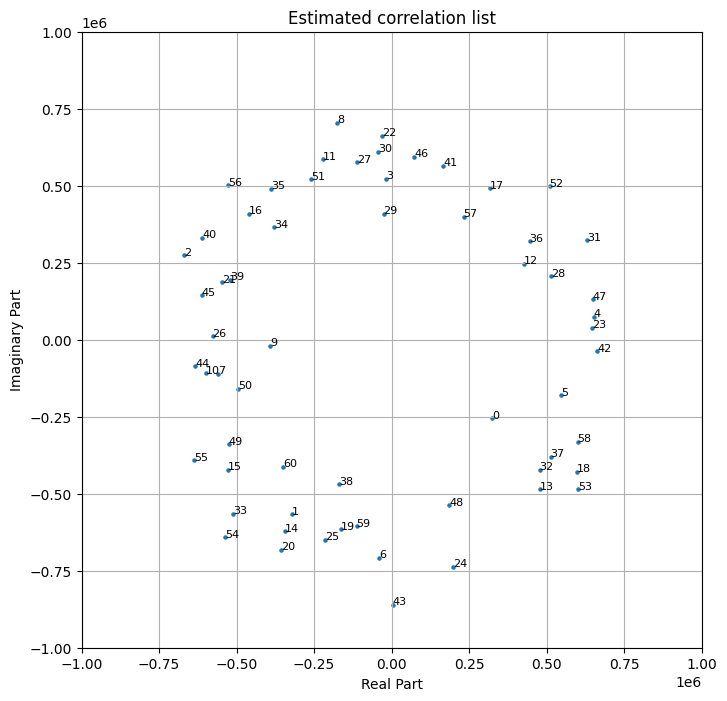

In [12]:
st = 0
num = 61
plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_result[st:st + num]), np.imag(cor_result[st:st + num]), s=5)#, color = "yellowgreen")

for i, txt in enumerate(range(0, num)):
    plt.annotate(f'{txt}', (np.real(cor_result[i+st]), np.imag(cor_result[i+st])), fontsize = 8)
    
#for i, txt in enumerate(range(0, 30)):
#    plt.annotate(f'{txt}', (np.real(cor_result[i+0]), np.imag(cor_result[i+0])), fontsize = 8)
        
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.xlim(-1e6,1e6)
plt.ylim(-1e6,1e6)
plt.show()

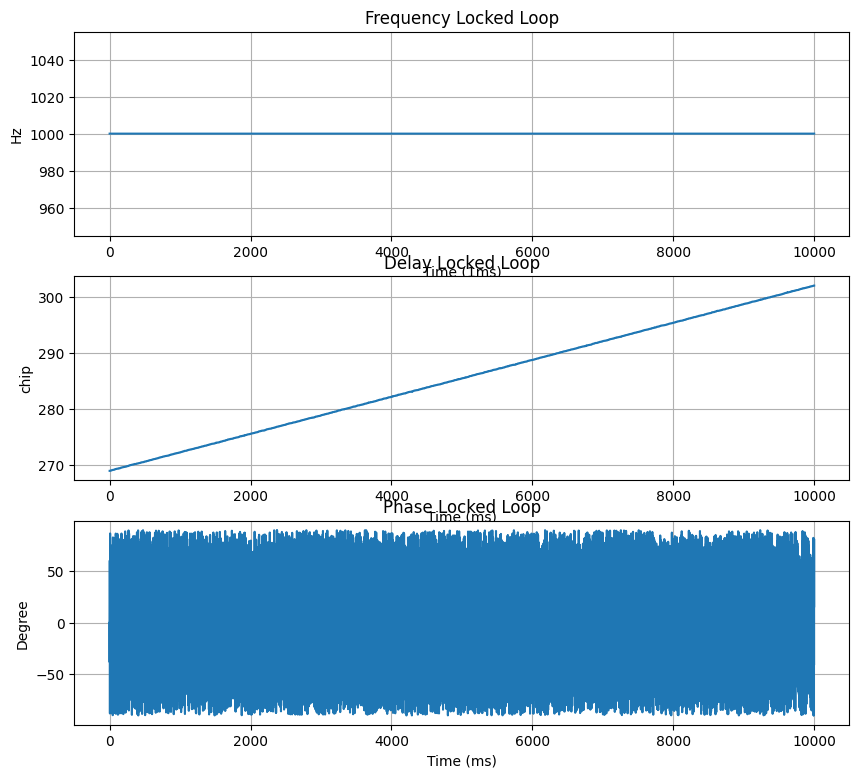

In [13]:
plt.figure(figsize=(10, 9))
t = np.arange(0,len(dop_freq_lst))

plt.subplot(3, 1, 1)
m = np.average(dop_freq_lst[:])
plt.plot(t[:], dop_freq_lst[:])
# plt.ylim(0.8*m, 1.2*m)
"""for i, v in enumerate(t):
    plt.text(v, dop_freq_lst[i], int(dop_freq_lst[i]),
            fontsize = 7,
            color = 'black',
            horizontalalignment = 'center',
            verticalalignment = 'bottom'
            )"""
    
plt.title('Frequency Locked Loop')
plt.xlabel('Time (1ms)')
plt.ylabel('Hz')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t,code_delay_lst)
"""for i, v in enumerate(t):
    plt.text(v, code_delay_lst[i], code_delay_lst[i] / OV,
            fontsize = 7,
            color = 'black',
            horizontalalignment = 'center',
            verticalalignment = 'bottom'
            )"""
plt.title('Delay Locked Loop')
plt.xlabel('Time (ms)')
plt.ylabel('chip')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t[:],phase_offset_lst_deg[:])
"""for i, v in enumerate(t):
    plt.text(v, phase_offset_lst_deg[i], int(phase_offset_lst_deg[i]),
            fontsize = 7,
            color = 'black',
            horizontalalignment = 'center',
            verticalalignment = 'bottom'
            )"""
plt.title('Phase Locked Loop')
plt.xlabel('Time (ms)')
plt.ylabel('Degree')
plt.grid(True)


bit-start position : 12
1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 

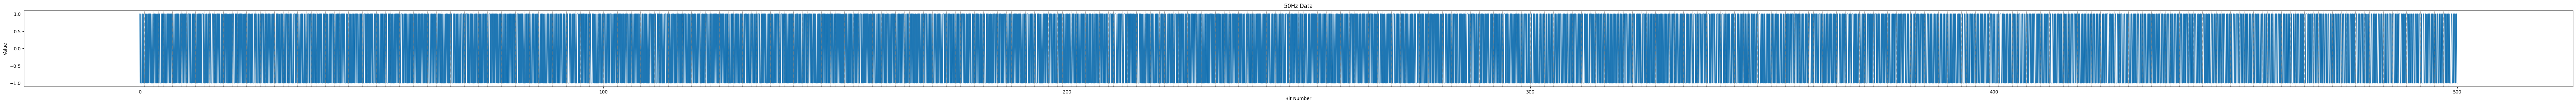

In [14]:
plt.figure(figsize = (100,3))
plt.title('50Hz Data')
t = np.arange(0,len(demod_result)//20,0.05)
plt.plot(t,demod_result[:10000])
plt.xlabel("Bit Number")
plt.ylabel("Value")
for i in range(0, len(demod_result)//20):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5)
plt.show
print('bit-start position :', start_pos)
print(*bit)

In [15]:
preamble = [1, 0, 0, 0, 1, 0, 1, 1]  # 10001011
preamble_inv = [1 - bit for bit in preamble]  # 01110100

# 프리앰블 검색 함수
def find_preamble_positions(bit_list, preamble, preamble_inv):
    positions = []
    bit_length = len(bit_list)
    preamble_length = len(preamble)
    phase = None  # 최초 프리앰블의 위상 (None: 아직 결정되지 않음)

    i = 0
    while i <= bit_length - preamble_length:
        # 현재 위치에서 시작하는 8비트 추출
        segment = bit_list[i:i + preamble_length]

        # 프리앰블 패턴과 비교
        if phase is None:
            # 최초 프리앰블 검색
            if segment == preamble:
                phase = 'normal'
                positions.append(i)
                i += preamble_length  # 프리앰블 길이만큼 이동
            elif segment == preamble_inv:
                phase = 'inverted'
                positions.append(i)
                i += preamble_length  # 프리앰블 길이만큼 이동
            else:
                i += 1  # 다음 비트로 이동
        else:
            # 최초 프리앰블 이후
            if phase == 'normal' and segment == preamble:
                positions.append(i)
                i += preamble_length  # 프리앰블 길이만큼 이동
            elif phase == 'inverted' and segment == preamble_inv:
                positions.append(i)
                i += preamble_length  # 프리앰블 길이만큼 이동
            else:
                i += 1  # 다음 비트로 이동

    return positions

# 프리앰블 위치 찾기
positions = find_preamble_positions(bit, preamble, preamble_inv)

# 결과 출력
print(f"프리앰블이 발견된 위치: {positions}")


프리앰블이 발견된 위치: [34, 346, 475]
